In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Step 1: Load Cleaned Data

In [2]:
# Load the cleaned listings file
df = pd.read_csv("../data/simplified/all_listings_cleaned.csv")

# Quick check
df.head()

,region,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,is_price_outlier
0,Santa Clara County,4952,Butterfly Inn near Stanford with weekly cleaning,7054,Mei Lin,Palo Alto,37.43932,-122.15741,Private room,72.0,3,96,2024-11-23,0.50,5,206,8,NaN,False
1,Santa Clara County,11464,Deluxe Studio near Kaiser SC:Traveler/Tesla in...,42458,Emey,Santa Clara,37.34415,-121.98701,Entire home/apt,101.0,3,25,2025-01-14,0.19,14,157,2,NaN,False
2,Santa Clara County,21026,Chi Home,79924,Khanh,San Jose,37.31760,-121.91577,Entire home/apt,450.0,2,14,2015-05-14,0.09,12,361,0,NaN,False
3,Santa Clara County,21028,"Zen home, Gated",79924,Khanh,San Jose,37.31534,-121.91598,Entire home/apt,350.0,2,8,2016-01-07,0.05,12,365,0,NaN,False
4,Santa Clara County,21373,Bonsai Garden near Stanford with weekly cleaning,7054,Mei Lin,Palo Alto,37.43972,-122.15532,Private room,80.0,5,285,2025-02-27,1.58,5,306,17,NaN,False


# Step 2: Create Price Bins (Labels)

In [3]:
# Use quantiles to define low, mid, high price tiers
df['price_bin'] = pd.qcut(df['price'], q=3, labels=["Low", "Mid", "High"])

# Check balance of classes
df['price_bin'].value_counts()

price_bin
Low     4224
Mid     4193
High    4188
Name: count, dtype: int64

# Step 3: Prepare Features & Target

In [4]:
# from sklearn.model_selection import train_test_split

In [5]:
# Drop non-numeric or ID columns you don't want as predictors
features = df[[
    'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
    'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
    'number_of_reviews_ltm'
]]
target = df['price_bin']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Step 4: Train a Classifier (e.g., Decision Tree)

In [6]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# Initialize and fit
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.72      0.31      0.43       838
         Low       0.44      0.84      0.58       845
         Mid       0.48      0.32      0.38       838

    accuracy                           0.49      2521
   macro avg       0.55      0.49      0.46      2521
weighted avg       0.55      0.49      0.46      2521



# Plot Confusion Matrix

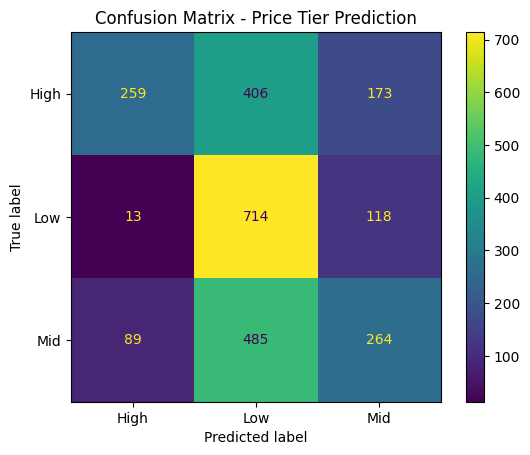

In [67]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix - Price Tier Prediction")
plt.show()

Model shows moderate performance, but it's clearly biased toward predicting the "Low" price bin
*  High recall for "Low" (0.84) → model is catching most low-price listings
*  Poor recall for "High" and "Mid" → lots of misclassifications into "Low"

# Improving Model Performance

## 1. Check Class Separability Visually
Plot pairwise feature distributions by price bin:

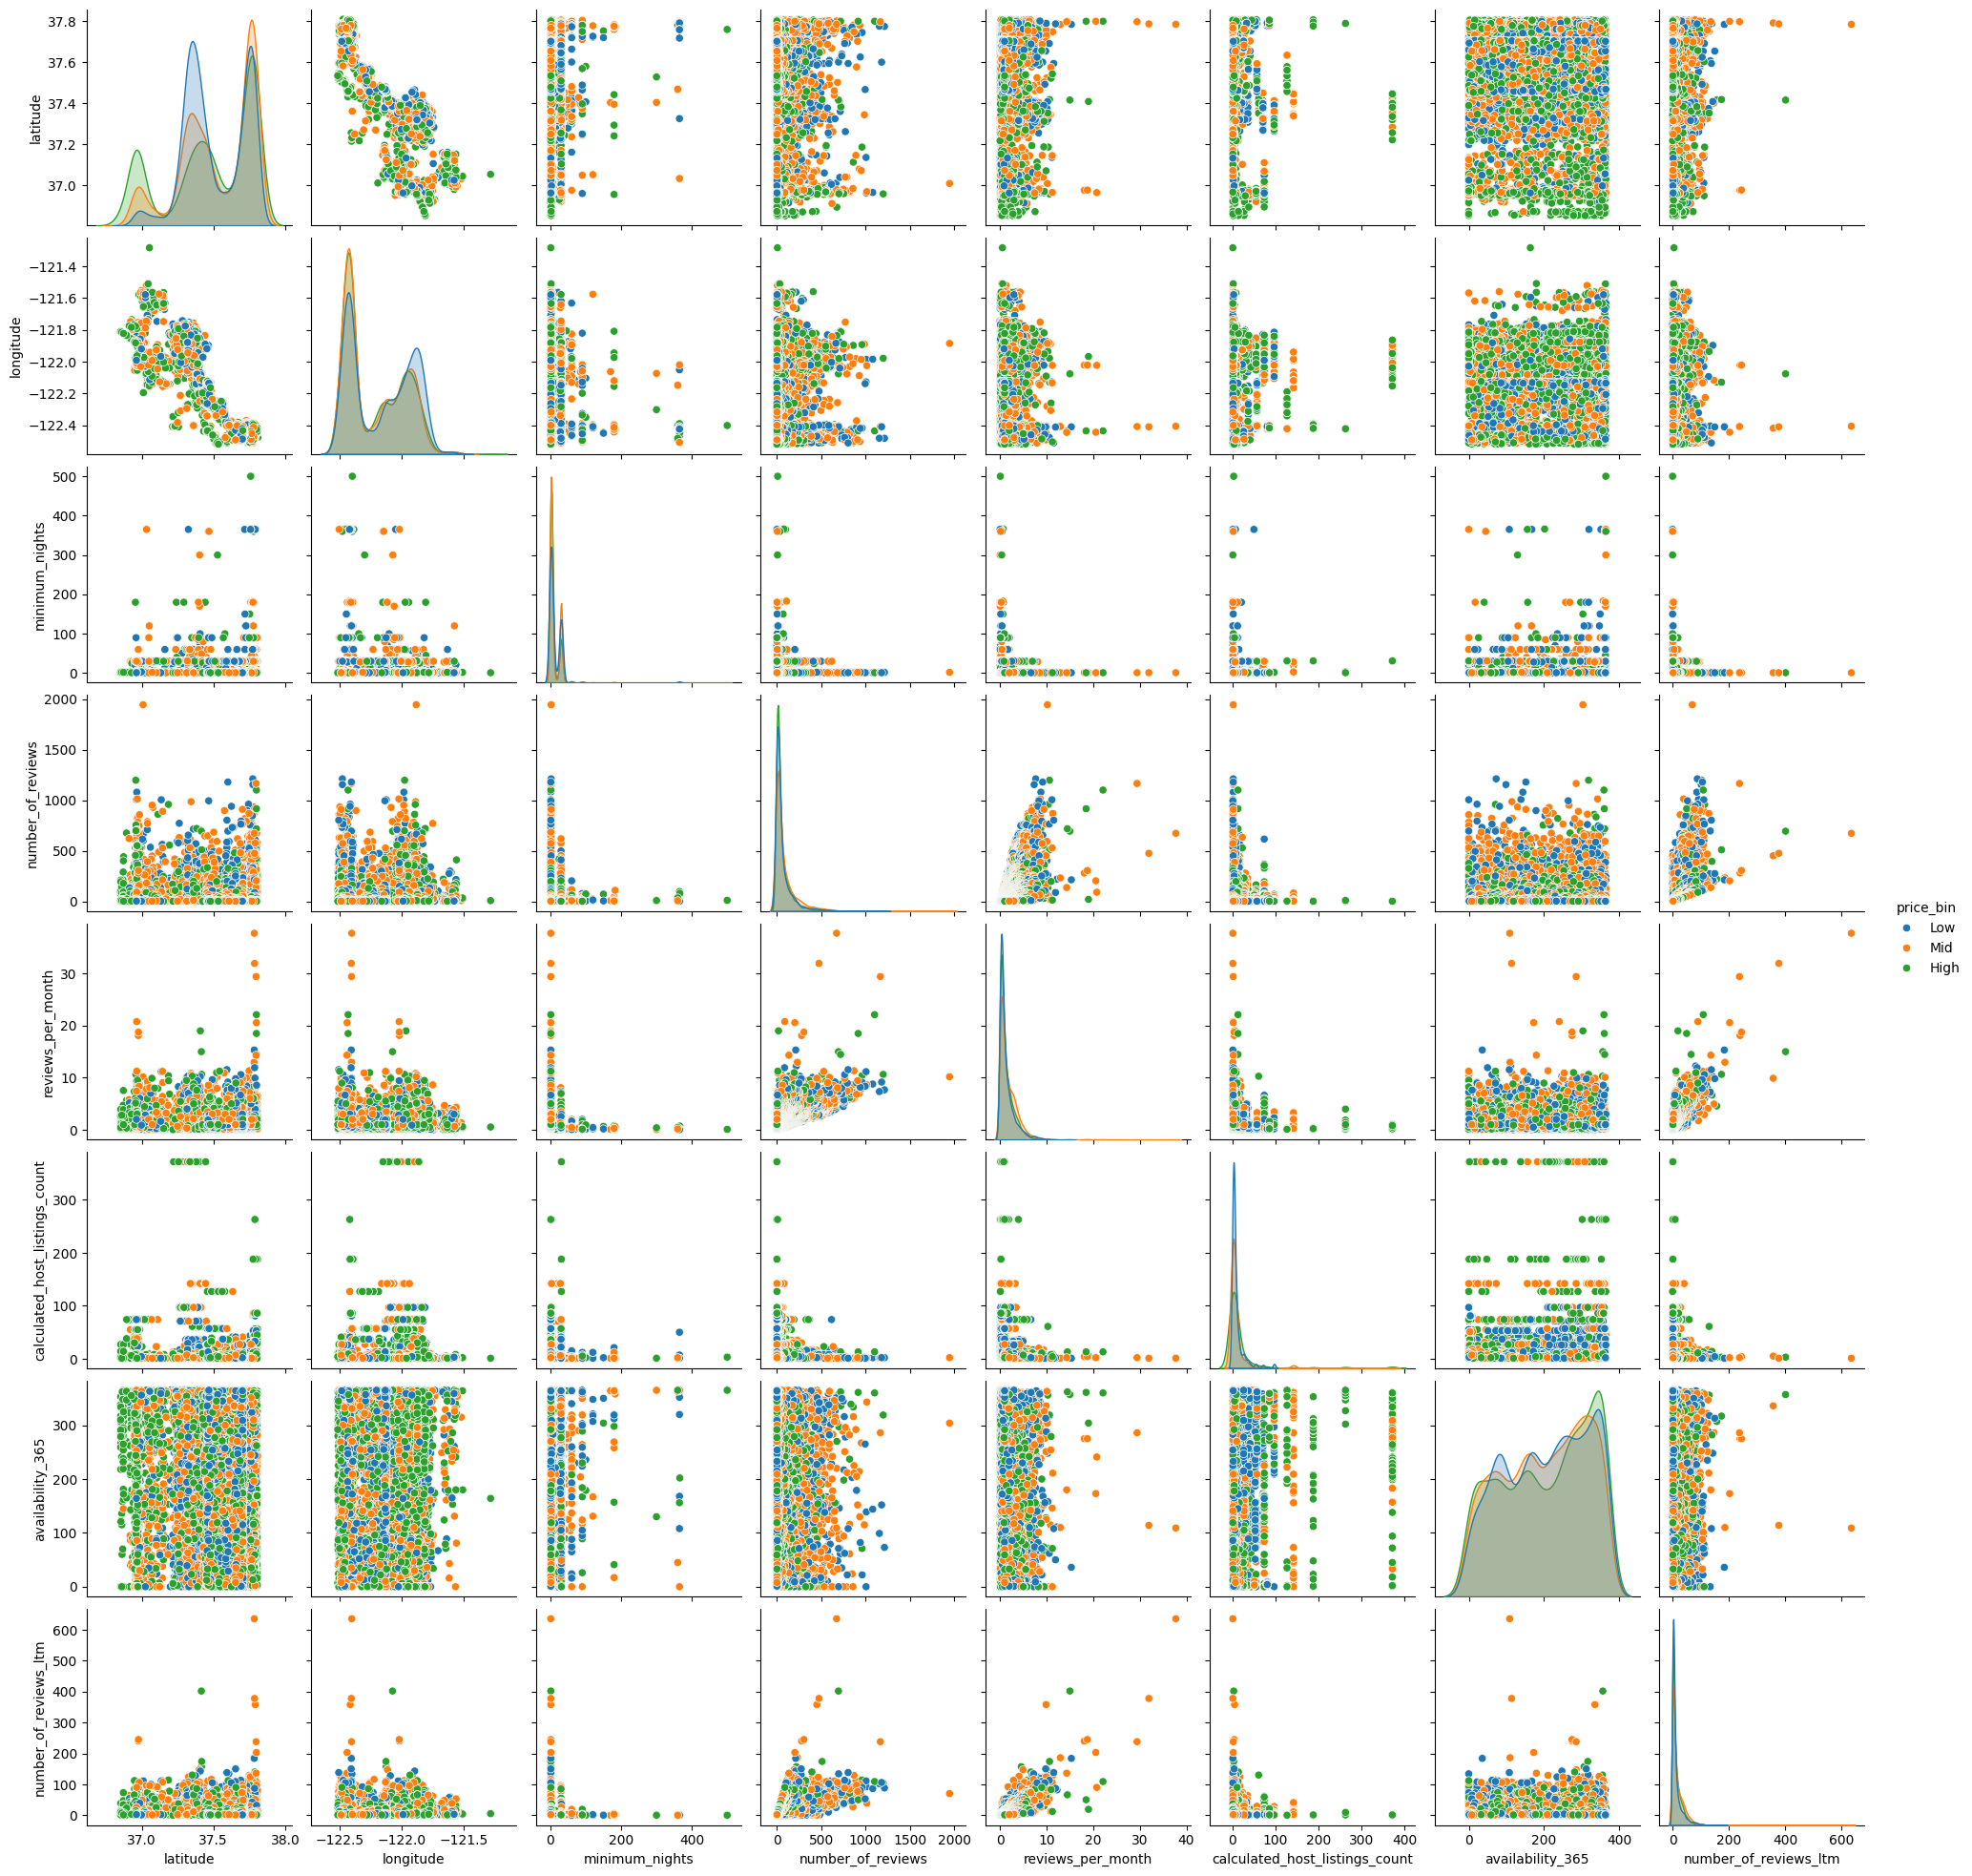

In [9]:
import seaborn as sns
sns.pairplot(df, vars=features.columns, hue='price_bin')

## 2. Try a Stronger Model (Random Forest / XGBoost)
Random forests often handle noise and nonlinear splits better.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))


              precision    recall  f1-score   support

        High       0.68      0.59      0.63       838
         Low       0.59      0.74      0.65       845
         Mid       0.53      0.47      0.50       838

    accuracy                           0.60      2521
   macro avg       0.60      0.60      0.59      2521
weighted avg       0.60      0.60      0.59      2521



## 3. Feature Engineering
Add categorical features like room_type, region using pd.get_dummies():

In [11]:
df_model = pd.get_dummies(df[features.columns.tolist() + ['room_type', 'region']], drop_first=True)


## 4. Normalize Features
Try a pipeline with scaling if models are sensitive:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42))
])
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

## 5. Stratified Cross-Validation
Get a better sense of model robustness:

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, features, target, cv=5, scoring='f1_macro')
print("F1 macro avg:", scores.mean())


F1 macro avg: 0.4012059585234039


# Next Steps in Analysis
##  1. Feature Importance Analysis
* Plot top features influencing predictions (feature_importances_ from the Random Forest)
* Identify which variables (e.g., room_type, availability_365, latitude, etc.) matter most

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("randomforestclassifier", RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [15]:
# Define features and target
features = ["latitude", "longitude", "minimum_nights", "number_of_reviews", 
            "reviews_per_month", "calculated_host_listings_count", 
            "availability_365", "number_of_reviews_ltm"]
target = "price_bin"

X = df[features]
y = df[target]

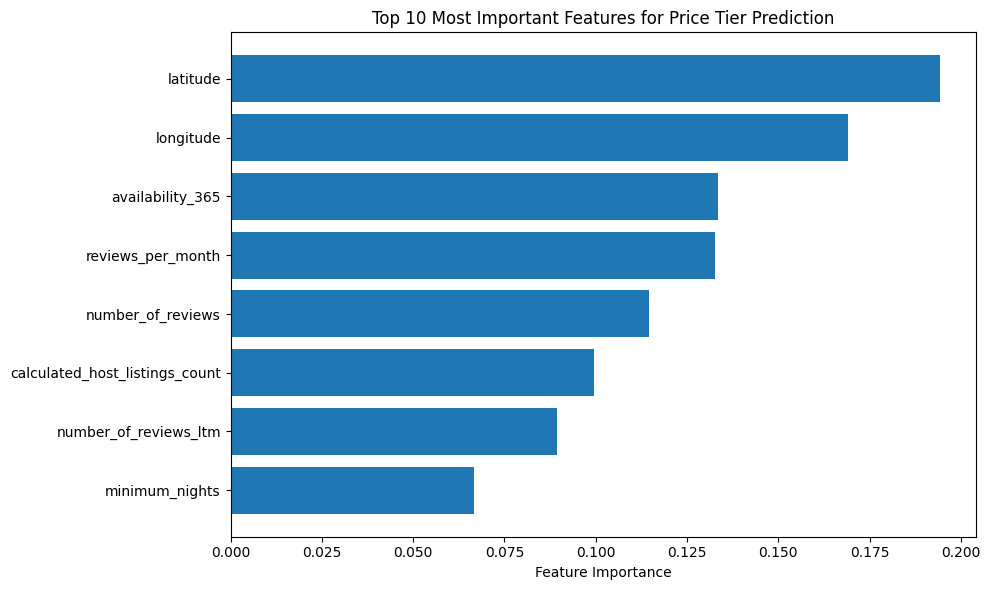

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pipeline.named_steps["randomforestclassifier"].feature_importances_
features = X.columns
feature_df = pd.DataFrame({"feature": features, "importance": importances})
feature_df = feature_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_df["feature"][:10], feature_df["importance"][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Most Important Features for Price Tier Prediction")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


## 2. Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to boost your model:
* Tune n_estimators, max_depth, min_samples_split, and class_weight
* Enable oob_score=True for cross-validation built into Random Forest

### Step 1: Define a Parameter Grid
* n_estimators: number of trees
* max_depth: max depth of trees
* min_samples_split: minimum samples to split a node
* class_weight: handling class imbalance
* oob_score: enabled via model init

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define your pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("randomforestclassifier", RandomForestClassifier(oob_score=True, random_state=42))
])

# Define hyperparameter grid
param_grid = {
    "randomforestclassifier__n_estimators": [100, 200],
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__class_weight": [None, "balanced"]
}


### Step 2: Run GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="f1_macro",  # You can also try 'accuracy' or 'recall_macro'
    verbose=2
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}


### Step 3: Evaluate Model

              precision    recall  f1-score   support

        High       0.69      0.62      0.65       838
         Low       0.65      0.73      0.69       845
         Mid       0.56      0.54      0.55       838

    accuracy                           0.63      2521
   macro avg       0.63      0.63      0.63      2521
weighted avg       0.63      0.63      0.63      2521



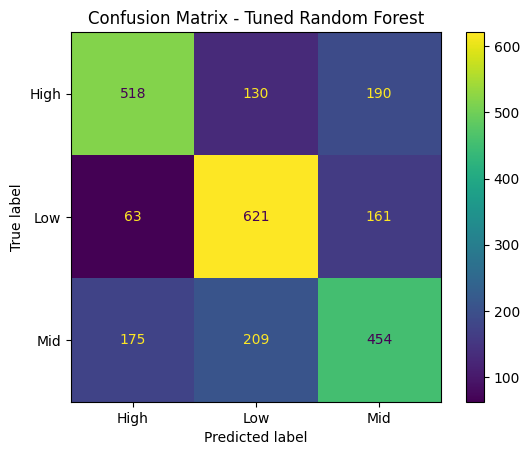

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()


## Visualize how performance varies across different hyperparameter values in your GridSearchCV using cv_results_.

### Step 1: Plot Grid Search Results (F1-macro vs Parameters)
We'll use grid_search.cv_results_ to create plots of how F1 score varies with:

* n_estimators
* max_depth
* min_samples_split
* class_weight

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Helper function to plot scores by a param
def plot_param_performance(param_name):
    plt.figure(figsize=(8, 5))

    # Convert the parameter column to string to avoid sorting issues with None
    results_df[f'param_{param_name}'] = results_df[f'param_{param_name}'].astype(str)

    sns.pointplot(x=f'param_{param_name}', y='mean_test_score', data=results_df)
    plt.title(f'Grid Search Score vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Mean F1 Macro Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Plot for each important parameter


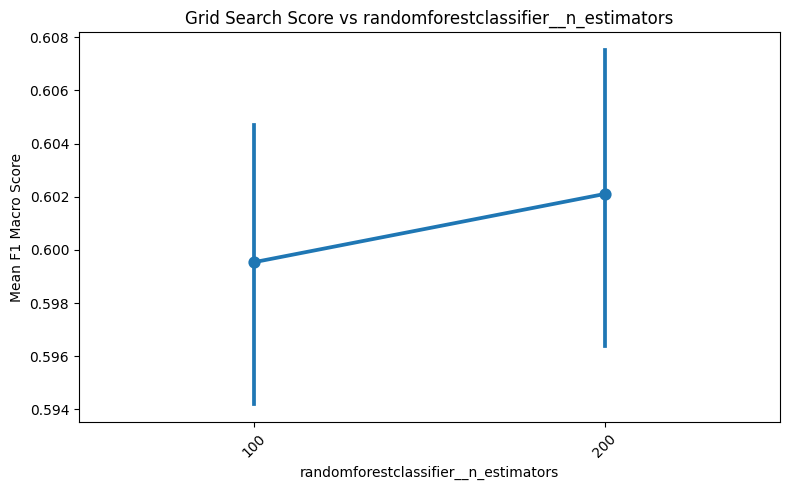

In [21]:
plot_param_performance("randomforestclassifier__n_estimators")

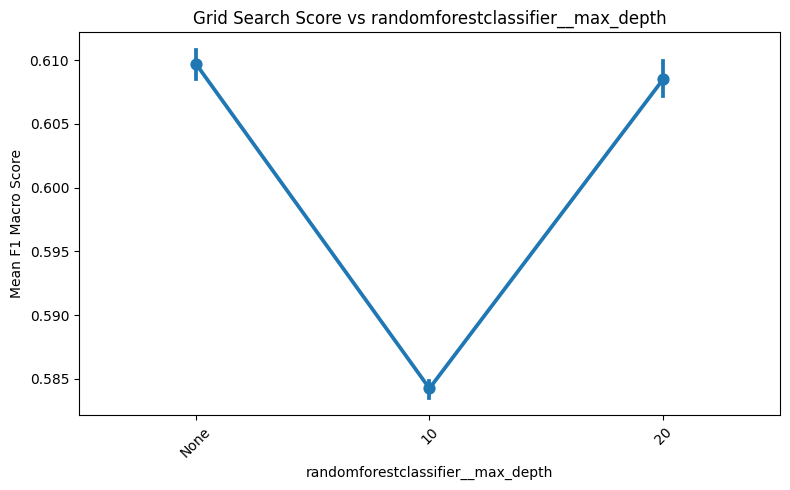

In [22]:
plot_param_performance("randomforestclassifier__max_depth")

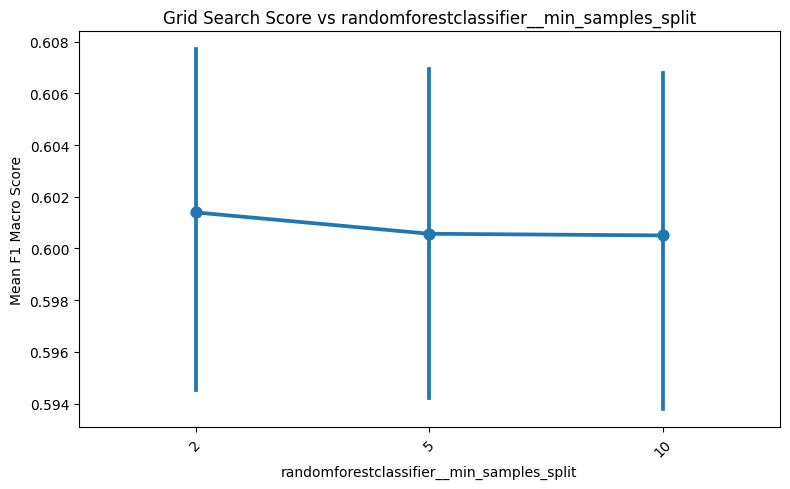

In [23]:
plot_param_performance("randomforestclassifier__min_samples_split")

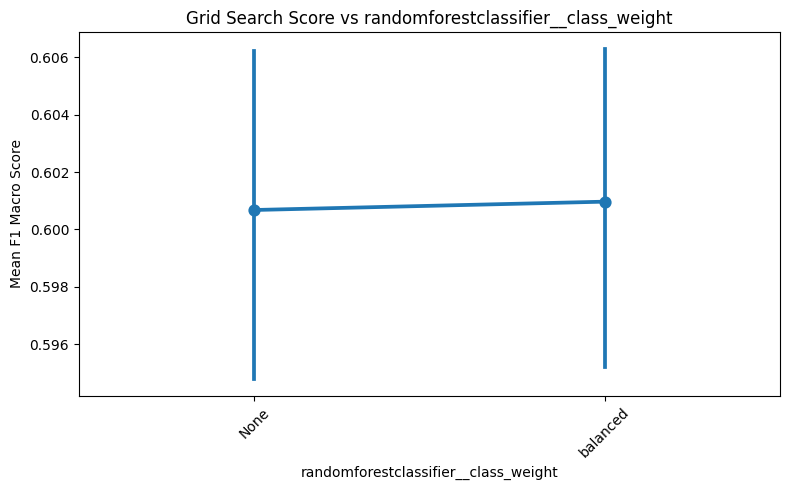

In [24]:
plot_param_performance("randomforestclassifier__class_weight")


Tuned Random Forest model is performing significantly better, especially on the High and Mid price tiers (accuracy ~63%, macro F1 ~0.63).

## Try RandomizedSearchCV for deeper tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define pipeline again if needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforestclassifier', RandomForestClassifier(random_state=42, oob_score=True))
])

# Define parameter grid for randomized search
param_distributions = {
    'randomforestclassifier__n_estimators': [100, 200, 300, 500],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}

# Set up the randomized search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to try
    scoring='f1_macro',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__class_weight': 'balanced'}


In [26]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.68      0.62      0.65       838
         Low       0.65      0.73      0.69       845
         Mid       0.55      0.53      0.54       838

    accuracy                           0.63      2521
   macro avg       0.63      0.63      0.63      2521
weighted avg       0.63      0.63      0.63      2521



## Confusion matrix

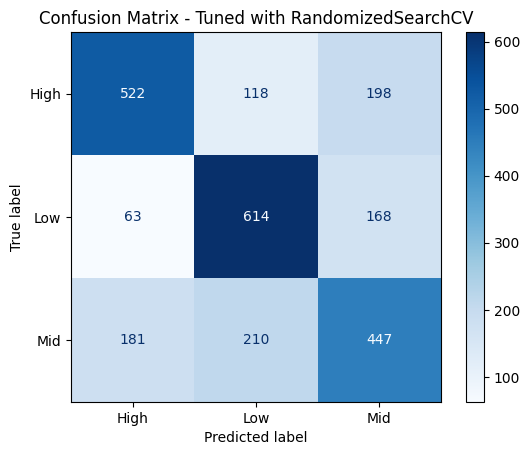

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=best_model.named_steps["randomforestclassifier"].classes_,
    cmap="Blues"
)
plt.title("Confusion Matrix - Tuned with RandomizedSearchCV")
plt.show()

## Plot the F1 scores by each parameter from your RandomizedSearchCV

In [28]:
results_df = pd.DataFrame(random_search.cv_results_)


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generalized plotting function
def plot_param_performance(param_name, results_df):
    plt.figure(figsize=(8, 5))
    # Drop rows with None to avoid sorting issues
    clean_df = results_df.dropna(subset=[f'param_{param_name}']).copy()
    
    # Convert 'None' to string if necessary (for mixed types)
    if clean_df[f'param_{param_name}'].dtype == object or clean_df[f'param_{param_name}'].isnull().any():
        clean_df[f'param_{param_name}'] = clean_df[f'param_{param_name}'].astype(str)
    
    sns.pointplot(
        data=clean_df,
        x=f'param_{param_name}',
        y='mean_test_score',
        errorbar='ci'
    )
    plt.title(f'F1 Macro Score vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Mean F1 Macro Score')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

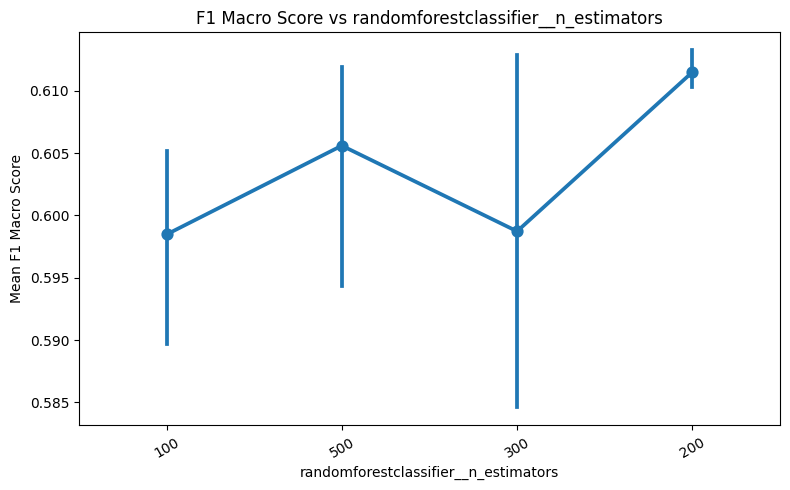

In [30]:
plot_param_performance("randomforestclassifier__n_estimators", results_df)

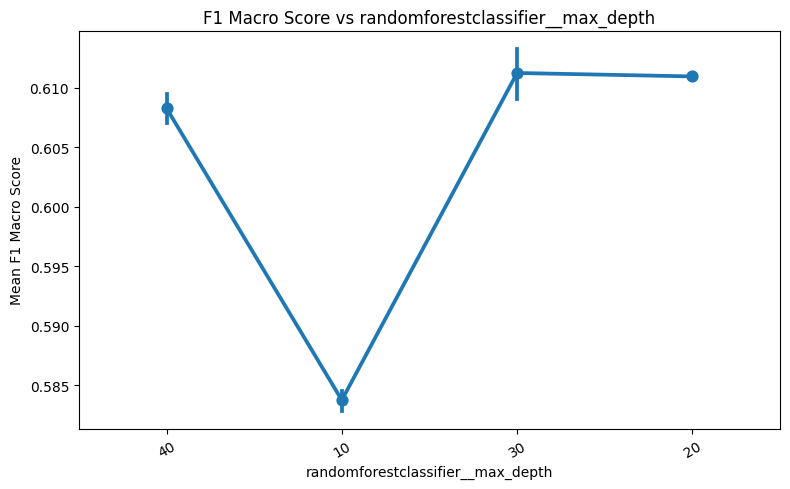

In [31]:
plot_param_performance("randomforestclassifier__max_depth", results_df)

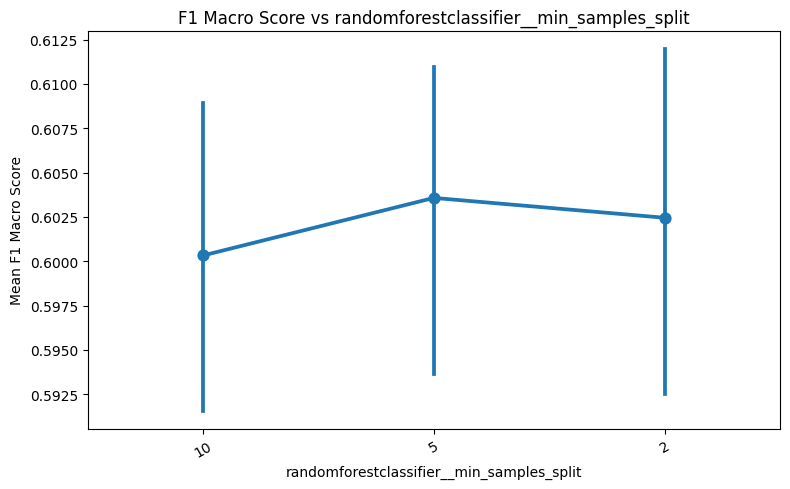

In [32]:
plot_param_performance("randomforestclassifier__min_samples_split", results_df)

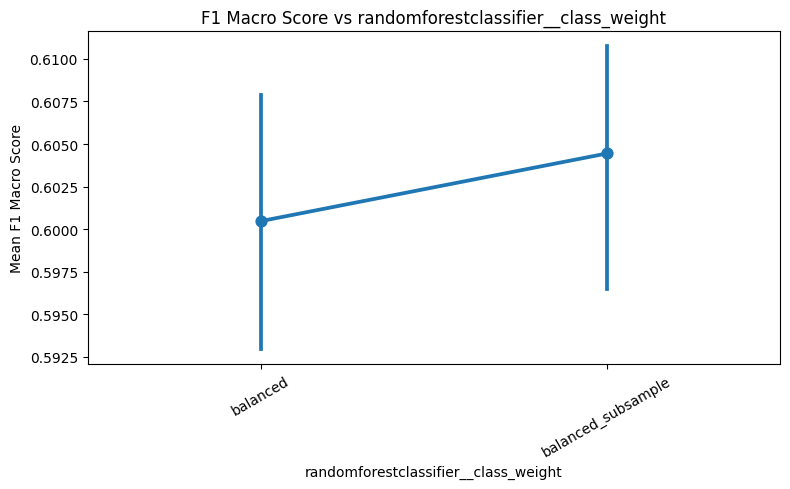

In [33]:
plot_param_performance("randomforestclassifier__class_weight", results_df)

### Visualize feature importances again from your tuned Random Forest model, showing the top features contributing to your price tier predictions:

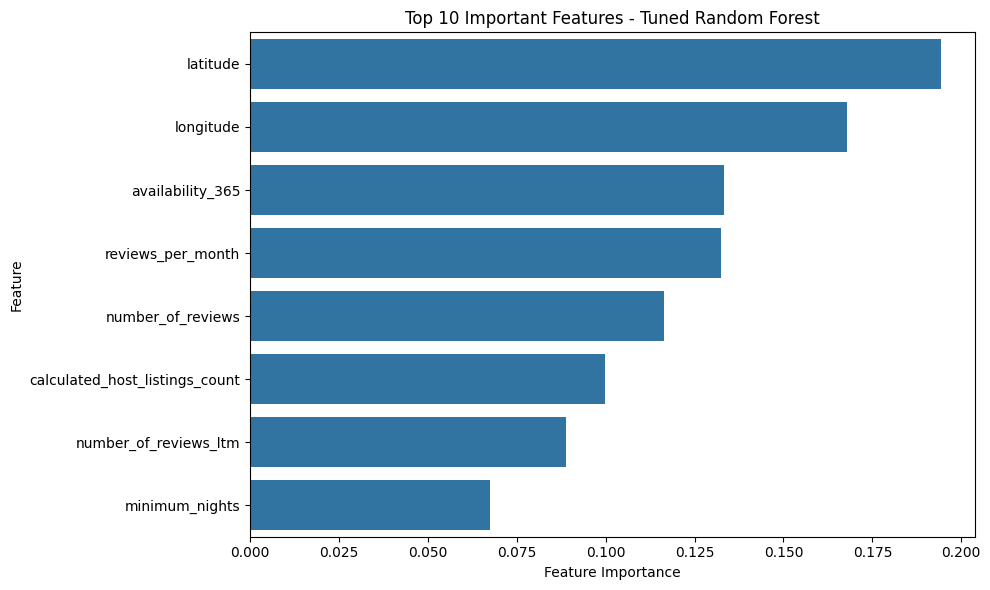

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use X_train columns as feature names
feature_names = X_train.columns

# Get feature importances from the tuned model
importances = best_model.named_steps["randomforestclassifier"].feature_importances_

# Create DataFrame and sort
feature_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_df.head(10))
plt.title("Top 10 Important Features - Tuned Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Detailed comparison of GridSearchCV vs RandomizedSearchCV based on my results and general usage

### 1. Parameter Search Strategy
| Aspect      | GridSearchCV                            | RandomizedSearchCV                          |
| ----------- | --------------------------------------- | ------------------------------------------- |
| Search Type | Exhaustive — tries **all combinations** | Random — tries a **subset of combinations** |
| Coverage    | Complete grid                           | Random sampling of parameter space          |
| Speed       | Slower (combinatorially explodes)       | Faster, especially for large grids          |
| Control     | More controlled and deterministic       | More flexible with distributions            |


### 2. Your Model Results
| Metric           | **GridSearchCV**                                                                     | **RandomizedSearchCV**                                                               |
| ---------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------ |
| Best Params      | `n_estimators=200`, `max_depth=20`, `min_samples_split=2`, `class_weight='balanced'` | `n_estimators=300`, `max_depth=30`, `min_samples_split=2`, `class_weight='balanced'` |
| Accuracy         | **0.63**                                                                             | **0.63**                                                                             |
| F1 Macro Avg     | **0.63**                                                                             | **0.63**                                                                             |
| Confusion Matrix | Slightly **better balance** across classes                                           | Slightly **worse Mid-class recall**                                                  |


### 3. Evaluation Insights
* Both searches yielded very similar performance (same macro F1: 0.63).
* RandomizedSearchCV found a different configuration that performs comparably but explored more of the hyperparameter space.
* GridSearchCV might miss better hyperparameters if your grid is too coarse.
* RandomizedSearchCV is more efficient if you have limited time or large search space.

### When to Use Each
| Situation                                | Recommended Method     |
| ---------------------------------------- | ---------------------- |
| Small search space, few parameters       | **GridSearchCV**       |
| Large space, many hyperparameters        | **RandomizedSearchCV** |
| Quick baseline tuning                    | **RandomizedSearchCV** |
| Final fine-tuning after RandomizedSearch | **GridSearchCV**       |


## 3. Try Gradient Boosting
Try other tree-based classifiers:
* XGBoost
* LightGBM
* HistGradientBoostingClassifier (built into sklearn)
- These may improve performance on your slightly imbalanced class problem.

### 1. XGBoost (XGBClassifier)

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Encode the target labels

In [36]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### Step 2: Define XGBoost classifier and hyperparameter space

In [37]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

### Step 3: RandomizedSearchCV

In [38]:
xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/workbench/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:36:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/workbench/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:36:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/workbench/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:36:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/workbench/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:36:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/workbench/.local/lib/python3.10/site-packages/

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 6, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='f1_macro', verbose=1)

### Step 4: Evaluation

In [39]:
print("Best XGBoost Params:", xgb_search.best_params_)

y_pred = xgb_search.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test, y_pred_labels))

Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

        High       0.67      0.63      0.64       838
         Low       0.66      0.69      0.67       845
         Mid       0.54      0.55      0.54       838

    accuracy                           0.62      2521
   macro avg       0.62      0.62      0.62      2521
weighted avg       0.62      0.62      0.62      2521



### Confusion matrix

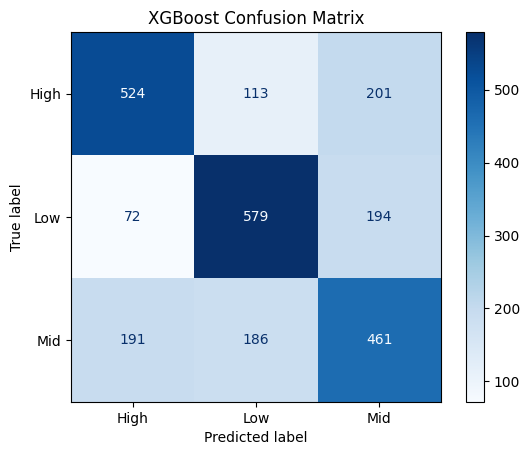

In [70]:
cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()


### Feature Importance for XGBoost
Visualize what’s driving predictions:

/tmp/ipykernel_13385/2070468505.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x="importance", y="feature", palette="Blues")


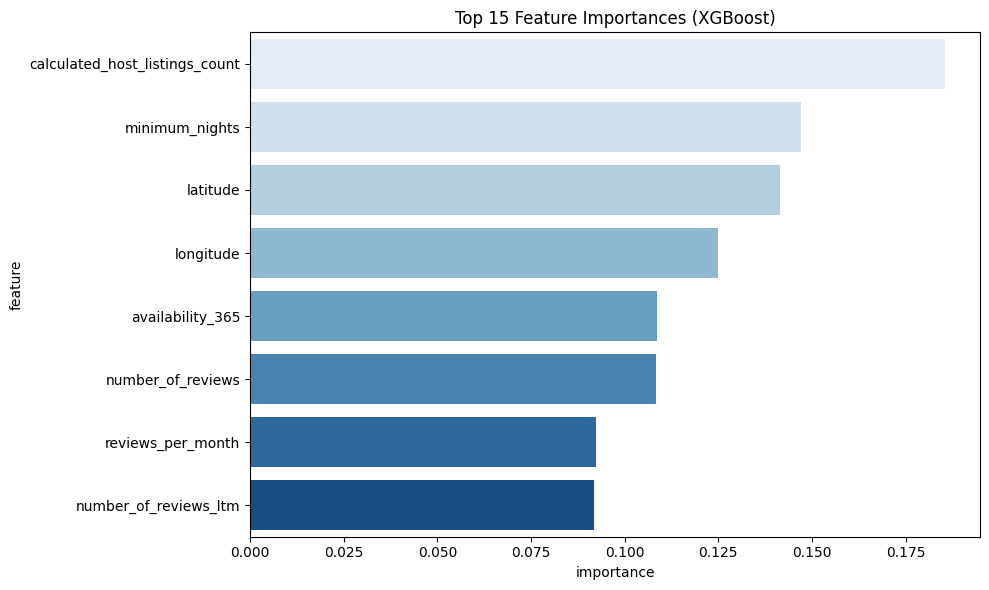

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances
xgb_best = xgb_search.best_estimator_
importances = xgb_best.feature_importances_

# Create DataFrame and sort
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature", palette="Blues")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


### 2. LightGBM (LGBMClassifier)

In [42]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)

lgbm_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, -1],
    "learning_rate": [0.01, 0.1, 0.2],
    "num_leaves": [31, 50, 100]
}

lgbm_search = RandomizedSearchCV(
    lgbm, param_distributions=lgbm_param_grid,
    n_iter=20, scoring='f1_macro', cv=5, verbose=1, n_jobs=1 # instead of the default -1
)

lgbm_search.fit(X_train, y_train)
print("Best LightGBM Params:", lgbm_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 8067, number of used features: 8
[LightGBM] [Info] Start training from score -1.101965
[LightGBM] [Info] Start training from score -1.093419
[LightGBM] [Info] Start training from score -1.100473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 8067, number of used features: 8
[LightGBM] [Info] Start training from score -1.101965
[LightGBM] [Info] Start training from score -1.093419
[LightGBM] [Info] Start training from score -1.100473
[LightGBM] [Info] Auto-choosing col-wise

Best LightGBM Hyperparameters:
{
  'num_leaves': 100,
  'n_estimators': 200,
  'max_depth': 20,
  'learning_rate': 0.2
}

#### Next Steps:
Evaluate the tuned model on your test set:

              precision    recall  f1-score   support

        High       0.68      0.62      0.65       838
         Low       0.64      0.70      0.67       845
         Mid       0.54      0.53      0.53       838

    accuracy                           0.62      2521
   macro avg       0.62      0.62      0.62      2521
weighted avg       0.62      0.62      0.62      2521



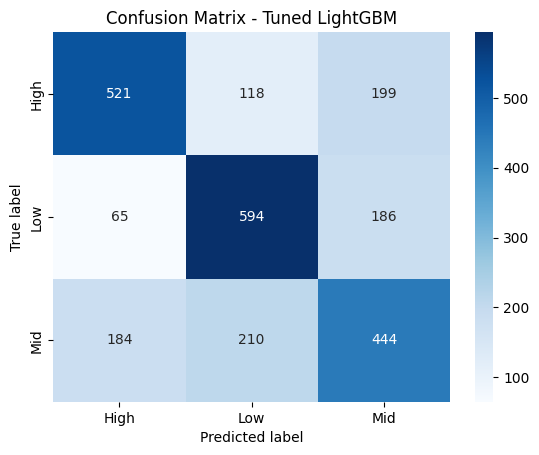

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reuse fitted encoder or fit again (only if y was encoded before)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y)  # Use your original target

# Predict
y_pred = lgbm_search.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Tuned LightGBM")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Visualize feature importances:

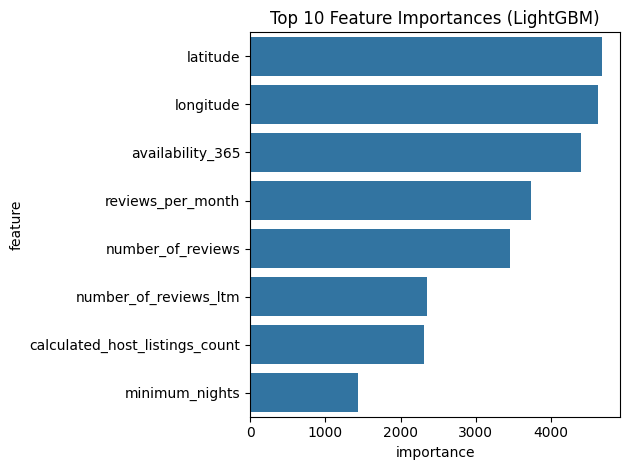

In [44]:
import pandas as pd

importances = lgbm_search.best_estimator_.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 10
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title("Top 10 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


### 3. HistGradientBoostingClassifier (sklearn)

In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define model
histgb = HistGradientBoostingClassifier(random_state=42)

# Define param grid
histgb_param_grid = {
    "max_iter": [100, 200, 300],
    "max_depth": [10, 20, None],
    "learning_rate": [0.01, 0.1, 0.2],
    "l2_regularization": [0.1, 1.0, 5.0]
}

# Randomized search
histgb_search = RandomizedSearchCV(
    histgb,
    param_distributions=histgb_param_grid,
    n_iter=20,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the search
histgb_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'l2_regularization': [0.1, 1.0, 5.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [10, 20, None],
                                        'max_iter': [100, 200, 300]},
                   scoring='f1_macro', verbose=1)

#### 1. Predict and Print Classification Report

In [46]:
from sklearn.metrics import classification_report

y_pred = histgb_search.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.69      0.61      0.65       838
         Low       0.64      0.71      0.67       845
         Mid       0.54      0.54      0.54       838

    accuracy                           0.62      2521
   macro avg       0.62      0.62      0.62      2521
weighted avg       0.62      0.62      0.62      2521



#### 2. Plot Confusion Matrix

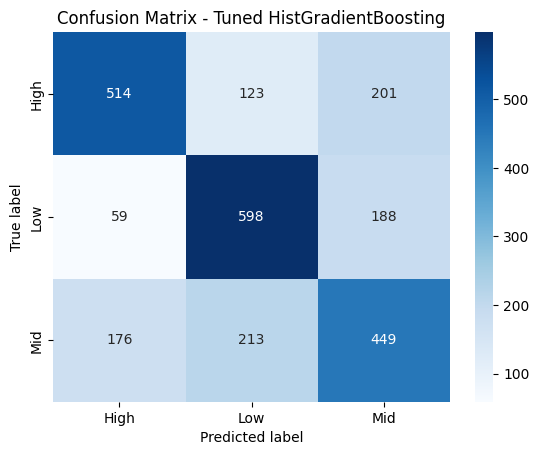

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["High", "Low", "Mid"],
            yticklabels=["High", "Low", "Mid"])
plt.title("Confusion Matrix - Tuned HistGradientBoosting")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


#### 3. Feature Importance (via Permutation Importance)

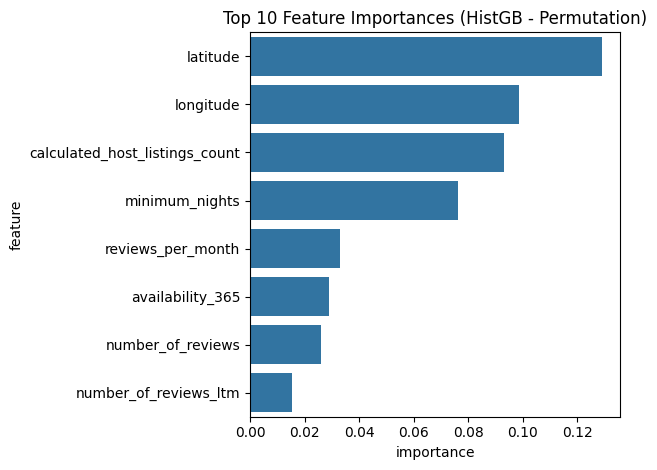

In [48]:
from sklearn.inspection import permutation_importance

result = permutation_importance(histgb_search.best_estimator_, X_test, y_test, scoring='f1_macro', n_repeats=10, random_state=42)
importances = result.importances_mean
feature_names = X_test.columns  # or use correct list if using pipeline

# Plot
import pandas as pd
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

sns.barplot(data=importance_df, x='importance', y='feature')
plt.title("Top 10 Feature Importances (HistGB - Permutation)")
plt.tight_layout()
plt.show()


## Evaluate Each Model
For each fitted model (random_forest, xgb_search, lgbm_search, hist_search):

### Plot all confusion matrices side-by-side

In [49]:
# Generate predictions from your best estimators
y_pred_rf = random_search.best_estimator_.predict(X_test)
y_pred_xgb = xgb_search.best_estimator_.predict(X_test)
y_pred_lgbm = lgbm_search.best_estimator_.predict(X_test)
y_pred_histgb = histgb_search.best_estimator_.predict(X_test)


In [50]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Decode test labels and predictions
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_rf_labels = y_pred_rf  # already string labels
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)
y_pred_lgbm_labels = y_pred_lgbm
y_pred_histgb_labels = y_pred_histgb


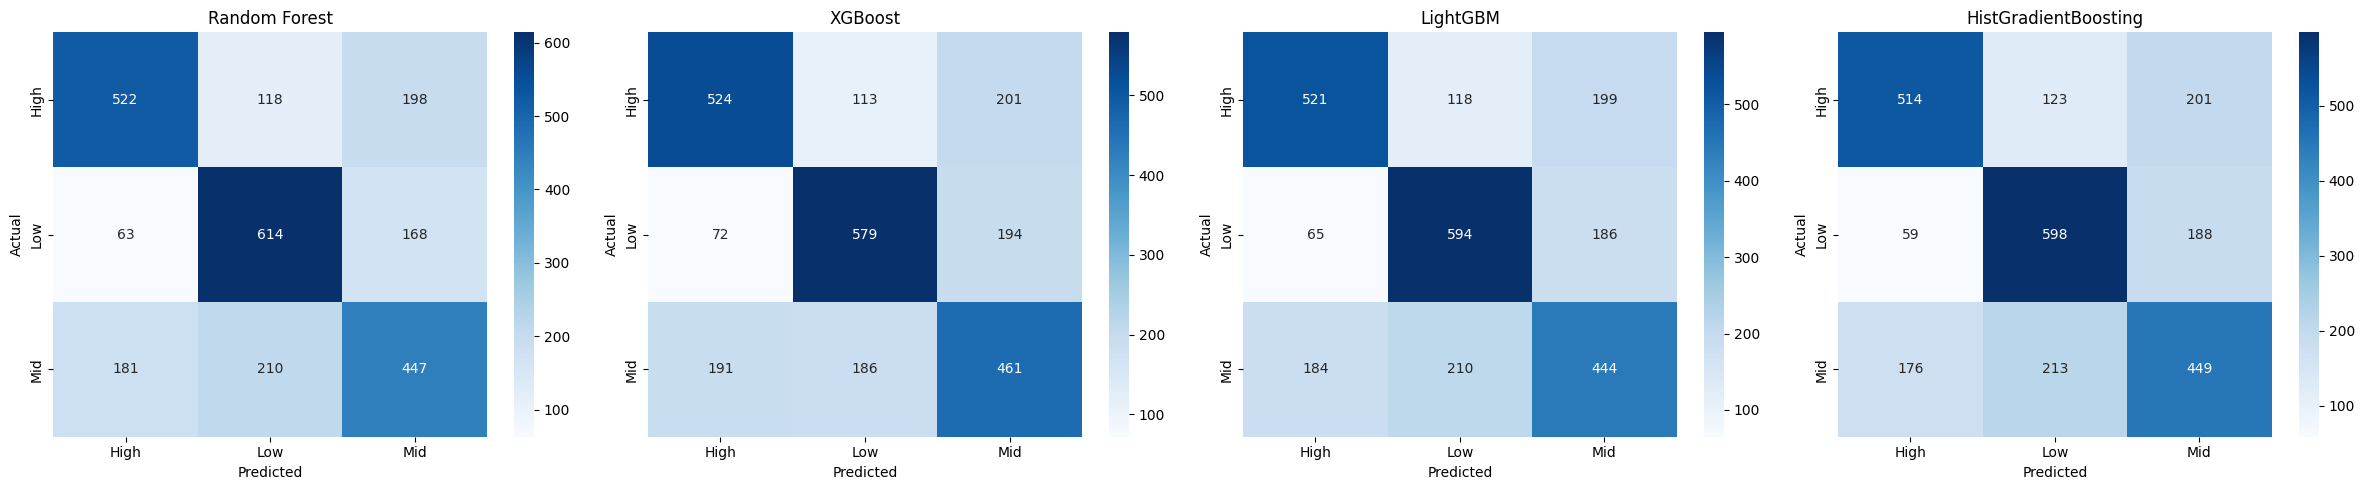

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure all values are strings
y_test_labels = y_test_labels.astype(str)
y_pred_rf_labels = y_pred_rf_labels.astype(str)
y_pred_xgb_labels = y_pred_xgb_labels.astype(str)
y_pred_lgbm_labels = y_pred_lgbm_labels.astype(str)
y_pred_histgb_labels = y_pred_histgb_labels.astype(str)

# Collect all unique labels used in test and predictions
all_labels = ['High', 'Low', 'Mid']

# Plot
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
titles = ['Random Forest', 'XGBoost', 'LightGBM', 'HistGradientBoosting']
preds = [y_pred_rf_labels, y_pred_xgb_labels, y_pred_lgbm_labels, y_pred_histgb_labels]

for ax, pred, title in zip(axes, preds, titles):
    cm = confusion_matrix(y_test_labels, pred, labels=all_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=all_labels, yticklabels=all_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


## 4. Handle Class Imbalance
* Use class_weight='balanced' in my  model RandomForestClassifier and HistGradientBoostingClassifier
* Or oversample/undersample:

* SMOTE (Synthetic Minority Over-sampling Technique)
* RandomOverSampler / RandomUnderSampler from imblearn



#### 1. Train Random Forest with class_weight='balanced'

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

#### 2. Predict on test set

In [53]:
y_pred_balanced_rf = rf_balanced.predict(X_test)

#### 3. Evaluation - Classification Report

In [54]:
print("Classification Report - Random Forest (Balanced):")
print(classification_report(y_test, y_pred_balanced_rf))

Classification Report - Random Forest (Balanced):
              precision    recall  f1-score   support

        High       0.66      0.61      0.64       838
         Low       0.64      0.73      0.68       845
         Mid       0.55      0.51      0.53       838

    accuracy                           0.62      2521
   macro avg       0.62      0.62      0.62      2521
weighted avg       0.62      0.62      0.62      2521



#### 4. Confusion Matrix

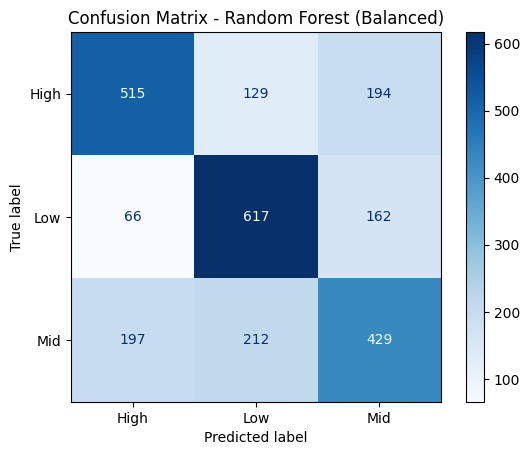

In [55]:
ConfusionMatrixDisplay.from_estimator(
    rf_balanced, X_test, y_test, display_labels=rf_balanced.classes_, cmap='Blues'
)
plt.title("Confusion Matrix - Random Forest (Balanced)")
plt.show()

#### Apply SMOTE (synthetic oversampling of minority classes) to X_train, y_train:

In [56]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original:", Counter(y_train))
print("SMOTE:", Counter(y_train_smote))


Original: Counter({'Low': 3379, 'Mid': 3355, 'High': 3350})
SMOTE: Counter({'High': 3379, 'Low': 3379, 'Mid': 3379})


#### Retrain the model on SMOTE data:

Classification Report - Random Forest (SMOTE):
              precision    recall  f1-score   support

        High       0.68      0.64      0.66       838
         Low       0.65      0.72      0.69       845
         Mid       0.56      0.53      0.54       838

    accuracy                           0.63      2521
   macro avg       0.63      0.63      0.63      2521
weighted avg       0.63      0.63      0.63      2521



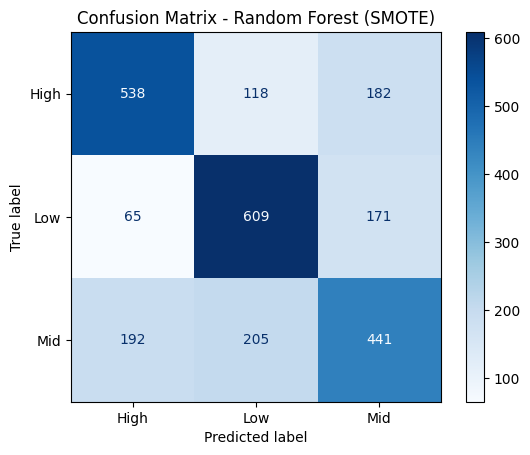

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = rf_smote.predict(X_test)

# Evaluation
print("Classification Report - Random Forest (SMOTE):")
print(classification_report(y_test, y_pred_smote))

ConfusionMatrixDisplay.from_estimator(rf_smote, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (SMOTE)")
plt.show()


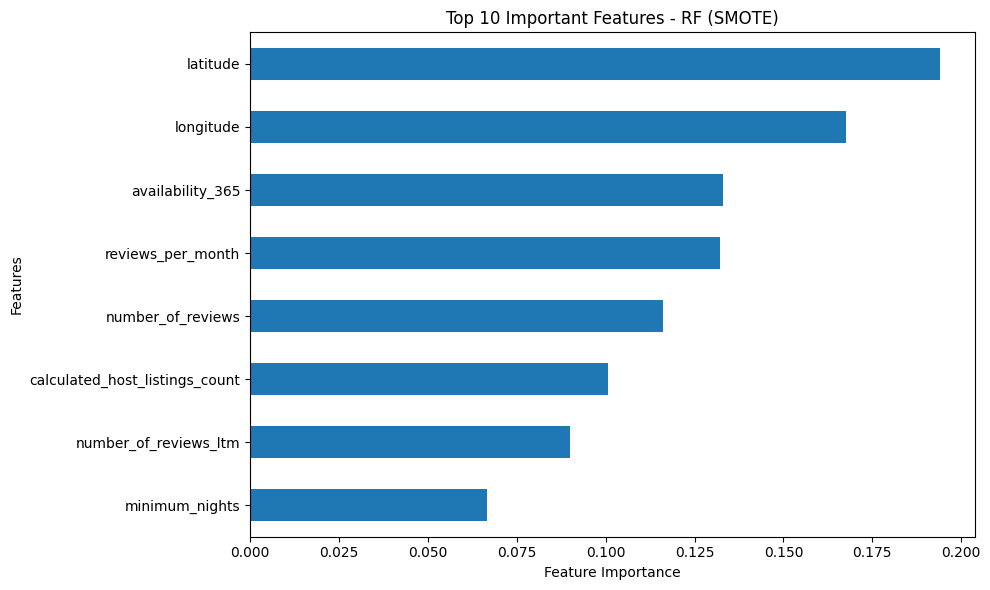

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'rf_smote' is your trained RandomForestClassifier model
# and 'X' is your DataFrame of features.

importances = rf_smote.feature_importances_
feat_importance = pd.Series(importances, index=X.columns)

# Get the top 10 features, sorted in descending order (largest to smallest)
top_10_features = feat_importance.nlargest(10) 

# Sort the Series in descending order for plotting
# By default, Pandas plots the first element at the bottom of the bar chart. 
# Reversing it before plotting will ensure the largest value appears at the top.
sorted_top_10_features = top_10_features.sort_values(ascending=True)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
sorted_top_10_features.plot(kind='barh')
plt.title('Top 10 Important Features - RF (SMOTE)')
plt.xlabel('Feature Importance') # Label the x-axis for clarity
plt.ylabel('Features') # Label the y-axis for clarity
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


# Key Takeaways from Feature Importance

| Feature                               | What it Means for Pricing Tier                                                                                                 |
| ------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **latitude / longitude**              | Location heavily influences price tier — proximity to city center or desirable areas likely correlates with "High" price tier. |
| **availability\_365**                 | More available listings may reflect hosts maximizing revenue (often pricier).                                                  |
| **reviews\_per\_month**               | A high review rate can signal popularity and justify higher pricing.                                                           |
| **number\_of\_reviews**               | Reflects listing's reputation and exposure; ties into perceived value.                                                         |
| **calculated\_host\_listings\_count** | Hosts with many listings may optimize pricing better, pushing listings into “Mid” or “High” tiers.                             |
| **minimum\_nights**                   | Longer minimum stays might reduce appeal, possibly pushing listing into lower tiers.                                           |


# Refine Your Features

### 1. distance_to_city_center
Why: Location is the top driver of Airbnb price. Converting latitude and longitude into a meaningful distance (e.g., from city center) makes it more interpretable and useful.

In [75]:
region_centers = {
    'San Francisco': (37.7749, -122.4194),
    'Santa Clara County': (37.3382, -121.8863),
    'San Mateo County': (37.4852, -122.2364),
    'Santa Cruz County': (36.9741, -122.0308)
}

# Add distance to region center
from geopy.distance import geodesic

df['distance_to_region_center'] = df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), region_centers[row['region']]).km, axis=1
)


#### Use region (county) as a categorical feature

In [76]:
df['region_encoded'] = df['region'].astype('category').cat.codes


### 2. host_experience_level
Why: More experienced hosts may have optimized pricing and better amenities, leading to higher tiers.

In [78]:
# Use number of listings to estimate experience
df['host_experience_level'] = pd.cut(
    df['calculated_host_listings_count'],
    bins=[0, 1, 3, 10, float('inf')],
    labels=['Newbie', 'Intermediate', 'Experienced', 'Superhost']
)


### 3. price_per_review
Why: Listings with high prices and few reviews might be overpriced. This feature could indicate value perception.

In [79]:
# Avoid division by zero
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)


# Updated Feature Set for Modeling

In [83]:
features = [
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'number_of_reviews_ltm',
    'region_encoded',
    'distance_to_region_center',
    'host_experience_level',
    'price_per_review'
]
target = 'price_bin'


### 1. Encode Categorical Features

In [84]:
# One-hot encode 'room_type' and 'host_experience_level'
X = pd.get_dummies(df[features], drop_first=True)

# Label encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df[target])


### 2. Train-Test Split

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


### 3. (Optional) Apply SMOTE for Imbalance

In [86]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


### 4. Train Model (Random Forest Example)

In [87]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

### 5. Evaluate Model

              precision    recall  f1-score   support

        High       0.91      0.90      0.90       838
         Low       0.89      0.86      0.87       845
         Mid       0.78      0.81      0.79       838

    accuracy                           0.86      2521
   macro avg       0.86      0.86      0.86      2521
weighted avg       0.86      0.86      0.86      2521



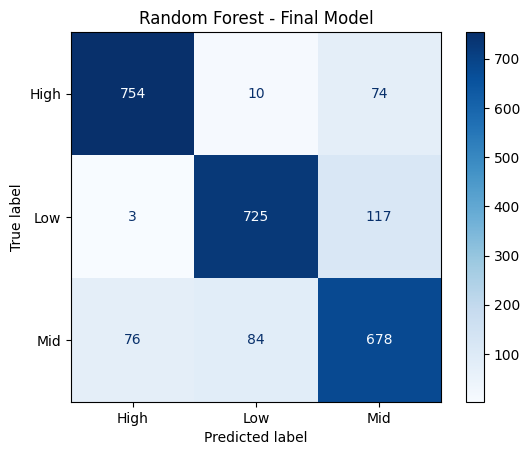

In [88]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=le.classes_, cmap="Blues")
plt.title("Random Forest - Final Model")
plt.show()


### 6. Feature Importance

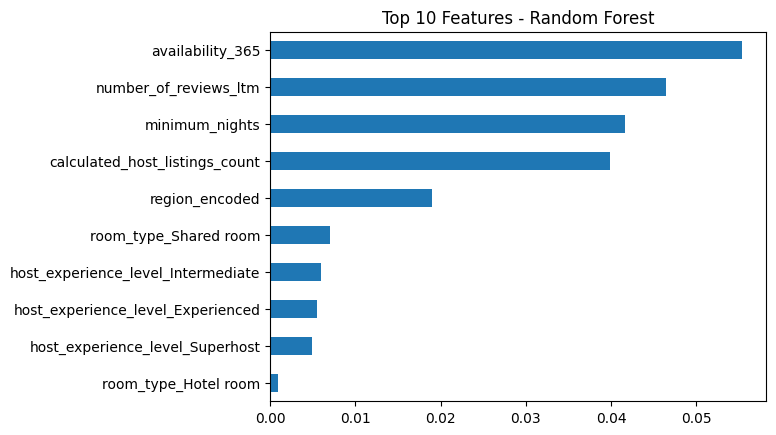

In [90]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True)
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Features - Random Forest")
plt.show()


# Side-by-side comparisons for XGB, LGBM, and HGB

Random Forest Accuracy: 0.8505
              precision    recall  f1-score   support

        High       0.90      0.89      0.90       838
         Low       0.89      0.85      0.87       845
         Mid       0.77      0.81      0.79       838

    accuracy                           0.85      2521
   macro avg       0.85      0.85      0.85      2521
weighted avg       0.85      0.85      0.85      2521



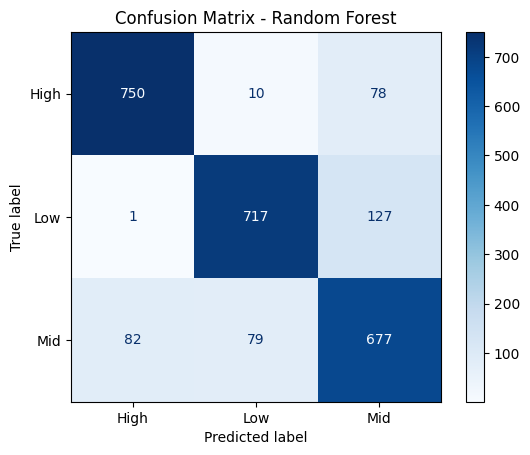

/home/workbench/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9758
              precision    recall  f1-score   support

        High       0.99      0.98      0.98       838
         Low       0.98      0.98      0.98       845
         Mid       0.96      0.97      0.96       838

    accuracy                           0.98      2521
   macro avg       0.98      0.98      0.98      2521
weighted avg       0.98      0.98      0.98      2521



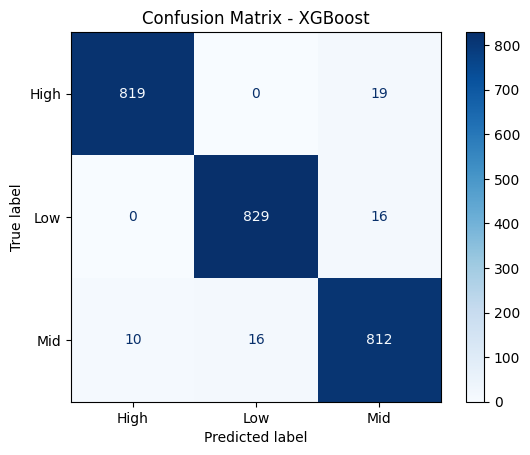

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 10084, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Accuracy: 0.9786
              precision    recall  f1-score   support

        High       0.99      0.98      0.99       838
         Low       0.98      0.98      0.98       845
         Mid       0.97      0.97      0.97       838

    accuracy                           0.98      2521
   macro avg       0.98      0.98      0.98      2521
weighted avg       0.98      0.98      0.98      2521



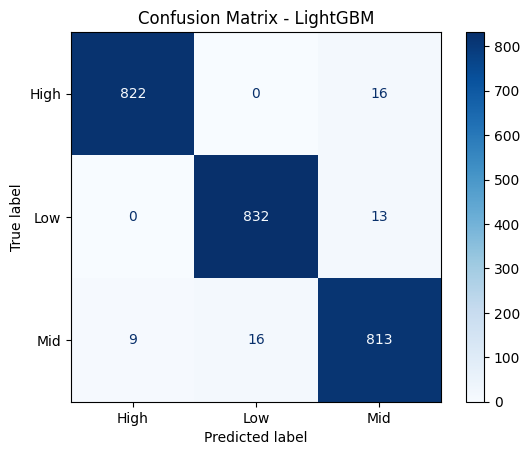

HistGradientBoosting Accuracy: 0.9750
              precision    recall  f1-score   support

        High       0.98      0.98      0.98       838
         Low       0.98      0.98      0.98       845
         Mid       0.96      0.97      0.96       838

    accuracy                           0.98      2521
   macro avg       0.98      0.97      0.98      2521
weighted avg       0.98      0.98      0.98      2521



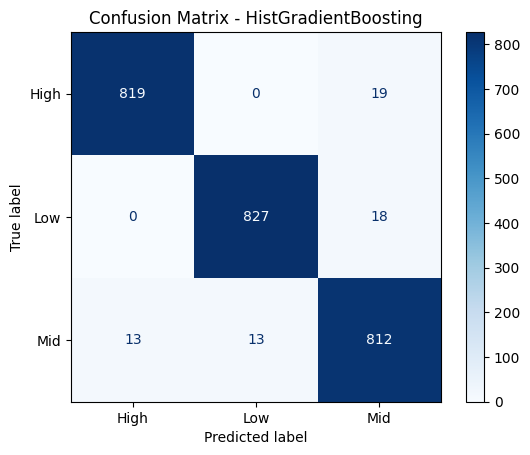

""


In [98]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Define the feature list and target
features = [
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'number_of_reviews_ltm',
    'region_encoded',
    'distance_to_region_center',
    'host_experience_level',
    'price_per_review'
]
target = 'price_bin'

# Only encode feature columns
df_encoded = pd.get_dummies(df[features], drop_first=True)

# Keep target separate and unencoded
y = df[target]

# Split data
# Now safe to proceed
X = df_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

# Store reports
results = {}

from sklearn.preprocessing import LabelEncoder

# Encode target labels (e.g., 'High', 'Mid', 'Low') into integers
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train_enc)  # use encoded labels
    y_pred = model.predict(X_test)

    # decode predictions back to string labels for evaluation
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test_enc)

    acc = accuracy_score(y_test_labels, y_pred_labels)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test_labels, y_pred_labels))
    ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# Display summary metrics
summary_df = pd.DataFrame({
    model: {
        "Accuracy": metrics["accuracy"],
        "F1 Score": metrics["f1_score"]
    }
    for model, metrics in results.items()
}).T

# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Summary", dataframe=summary_df)

summary_df


# Summary of Model Performance
| Model                    | Accuracy | Notes                                                  |
| ------------------------ | -------- | ------------------------------------------------------ |
| **Random Forest**        | 0.85     | Solid baseline; slight underperformance on "Mid" class |
| **XGBoost**              | 0.976    | Great accuracy; minimal misclassifications             |
| **LightGBM**             | 0.979    | Best performance overall; clean confusion matrix       |
| **HistGradientBoosting** | 0.975    | Comparable to XGBoost; performs well on all classes    |


# Export the best model

In [111]:
import joblib
joblib.dump(models["LightGBM"], "airbnb_price_classifier_LightGBM.pkl")


['airbnb_price_classifier_LightGBM.pkl']

## 5. Model Interpretation
* Use SHAP values or LIME to explain specific predictions
* This is helpful if your goal includes actionable insights (e.g., for a host dashboard)



In [194]:
lgbm_search = models["LightGBM"]

#### Prepare Explainer and SHAP Values

In [195]:
# Initialize TreeExplainer for your trained model
explainer = shap.TreeExplainer(lgbm_search)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)


In [196]:
explainer = shap.TreeExplainer(lgbm_search)
shap_values = explainer.shap_values(X_test)


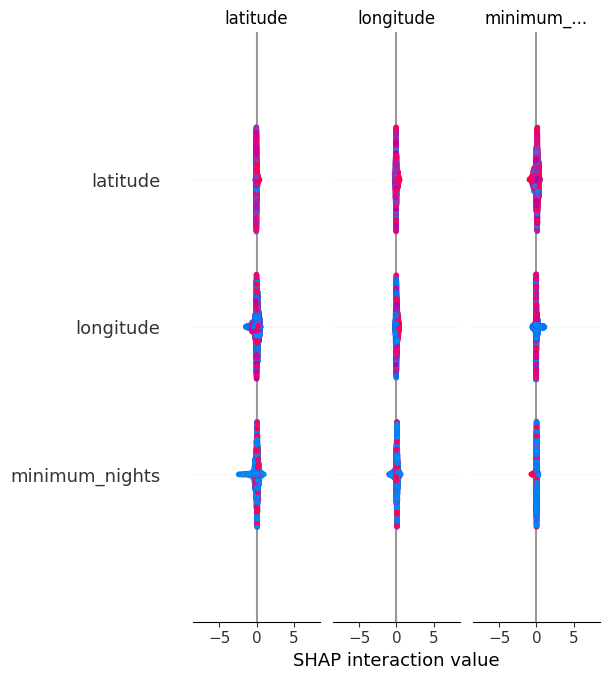

In [197]:
# Get the actual class names
class_names = label_encoder.classes_

# Plot SHAP summary plot with correct class names
shap.summary_plot(shap_values, X_test, class_names=class_names)


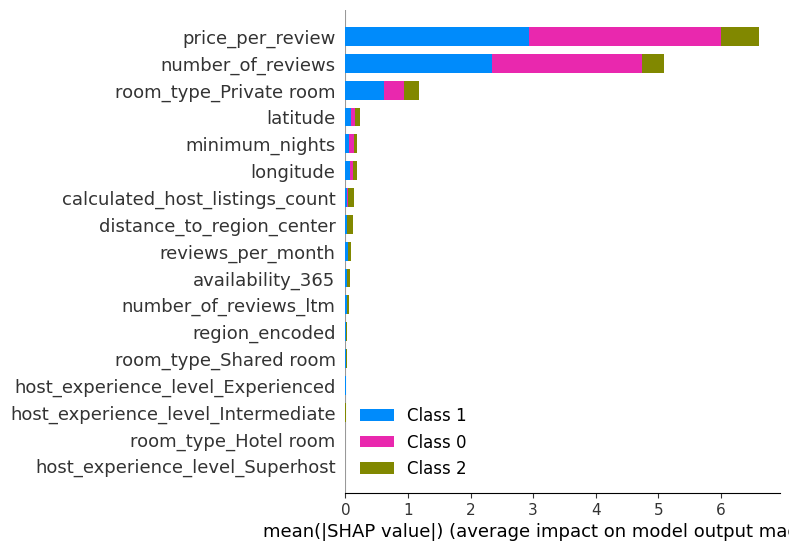

In [198]:
import matplotlib.pyplot as plt

# Increase figure size for clarity
plt.figure(figsize=(10, 6))

# Create SHAP bar plot without immediately displaying it
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Adjust bottom margin to make room for x-axis label
plt.tight_layout()
plt.subplots_adjust(bottom=0.4)  # Increase this if it's still getting cut

# Display final plot
plt.show()


#### Summary Plot

## 6. Deploy or Package the Project
* Save your cleaned dataset, pipeline, and results
* Optionally, wrap the model into a Streamlit or Flask app for demo
* Or publish the notebook + markdown summary to GitHub with visuals



#### 1. Save Your Cleaned Dataset

In [191]:
df.to_csv("final_clean_engineered_listings.csv", index=False)

#### 2. Save the Trained Model & Pipeline

In [199]:
import joblib
# Save model
joblib.dump(models["LightGBM"], "airbnb_price_classifier_LightGBM.pkl")

# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")

# save the original X_train.columns to disk to use with the app
joblib.dump(X.columns.tolist(), "X_cols.pkl")

['X_cols.pkl']

#### 3. Wrap It Into a Simple App (Optional)

##### Option A: Streamlit Demo App

In [193]:
import streamlit as st
import pandas as pd
import joblib

# Load model and encoder
model = joblib.load("airbnb_price_classifier_LightGBM.pkl")
label_encoder = joblib.load("label_encoder.pkl")

st.title("Airbnb Price Tier Predictor")

# Input form
room_type = st.selectbox("Room Type", ["Entire home/apt", "Private room", "Shared room", "Hotel room"])
latitude = st.number_input("Latitude", value=37.77)
longitude = st.number_input("Longitude", value=-122.41)
minimum_nights = st.number_input("Minimum Nights", value=1)
# Add more inputs as needed...

# Prediction
if st.button("Predict"):
    # Create input DataFrame (with dummy structure matching training data)
    input_df = pd.DataFrame({...})  # fill with appropriate one-hot or dummy values
    
    pred = model.predict(input_df)
    st.write(f"Predicted Price Tier: {label_encoder.inverse_transform(pred)[0]}")


2025-07-14 23:24:22.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.733 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.733 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 23:24:22.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

##### Option B: Flask API

4. Publish Your Work
Notebook: Export .ipynb → .md or HTML using Jupyter

README.md: Add a summary with visuals (shap plots, confusion matrix, etc.)

GitHub: Include:

cleaned_airbnb_data.csv

airbnb_price_classifier_LightGBM.pkl

label_encoder.pkl

Visuals (SHAP, confusion matrices)

Notebook with exploration and modeling steps